## Goal:

[MAGIC](https://www.cell.com/action/showPdf?pii=S0092-8674%2818%2930724-4) provides a cool & fast way of denoising data, especially for rare words/genes, by borrowing information across cells. It may help my task ([challenge](https://zihao12.github.io/pyJSMF-RAW/issues_finding_anchor_word)) here, in two ways below:

## Notation

* $X_{ij}$ gene $j$ in cell $i$
* $Y = X^T$ so $Y_{ij}$ gene $i$ in cell $j$

### Apply MAGIC TO $X$
Denoising, particularly for rare genes. Hope is by borrowing info from similar cells, we can get better vector for rare genes

### Apply MAGIC to $Y = X^T$
Not standard usage. We hope to achieve shrinkage. We form a similarity measure between genes, and use this to form a transition matrix, then multiply to  shrink the original matrix (though it seems the transition matrix ia what we want)

### Why MAGIC to $Y = X^T$ works?

* First we construct affinity matrix $D$ for genes, then scale it into transition matrix $M$, then get imputed matrix $Y^{\text{impute}} = M^t Y$ or $Y^{\text{impute}}_{ij} = \sum_k (M^t)_{ik} Y_{kj}$: imputation for gene $i$ in cell $j$ is weighted average of genes in that same cell; the weights are the transition probability from gene $i$ to gene $k$ in $t$ steps.

* The vector for rarer genes are shorter and have wider-ranging angles (more likely to appear extreme). However, our affinity matrix will group those shorter vectors as neighbors, and imputation becomes averaging over those shorter vectors, effectively shrinking them towards the center. 

* Problem is noise may lead to bad affinity matrix, and thus leads to over-shrinkage. For example, a true anchor word is also rather rare, then affinity matrix will decide its neighbors are those short and noisy vectors. Then imputation on this anchor word will smooth out true information. 

* Power parameter $t$ plays a big role here; also the strategy for choosing adaptive gaussian kernel width (in forming affinity matrix) for each gene might be tweaked. 


### Comments

* The best performance (returned anchor words are very close to true anchor words in both true $\bar{C}$ and $\hat{\bar{C}}$) is attained by: learning diffusion map using $X^T$ (whether to scale each gene to have the same sum both work quite well!!; then take square root); apply diffusion to denoise $X^T$ with appropriate diffusion steps $t$; then form $\bar{C}$ using the denoised $X$

* Seems something wrong with SPA when directly using diffusion map to find anchor words

* I'm surprised that scaling each gene to have equal sum doesn't make the diffusion map very bad

* Why smoothing $\bar{C}$ does not give better result?  

In [1]:
import os
import sys
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import numpy as np
import time
import pickle
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

from scipy.stats import betabinom
from scipy.optimize import minimize
import magic
import scprep


script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions4 import *
from misc import *
from sinkhorn import * 

datadir = "../../../gdrive/github_data/pyJSMF-RAW-data"
# %matplotlib widget

np.random.seed(123)

In [2]:
%%capture

## load data
dataname = "sla"
k = 6
rate=3

datafile=f"{datadir}/fit_sim_{dataname}_fastTopics_k{k}_rate{rate}.pkl"
with open(datafile, "rb") as f:
    fitted = pickle.load(f)
    

X = fitted['X']
Ltrue = fitted['Ltrue']
Ftrue = fitted['Ftrue']
n, p = X.shape


Pi_true = Ltrue @ Ftrue.T


# truth
Ctrue = Pi_true.T @ Pi_true / n
Cbar0 = Ctrue / Ctrue.sum(axis = 1)[:, None]


S0, _, _ = findS(Cbar0, k)
Cbar0_pj = pca_proj(Cbar0)


## MAGIC on $X$

In [3]:
X_normalized = scprep.normalize.library_size_normalize(X)
X_normalized = scprep.transform.sqrt(X_normalized)
magic_op = magic.MAGIC()
magic_op.set_params(random_state = 12, t = 3)
magic_op.fit(X_normalized)
X_magic = magic_op.transform(X)

Running MAGIC on 3207 cells and 8766 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 0.61 seconds.
  Calculating KNN search...
  Calculated KNN search in 1.05 seconds.
  Calculating affinities...
  Calculated affinities in 1.03 seconds.
Calculated graph and diffusion operator in 2.70 seconds.
Running MAGIC with `solver='exact'` on 8766-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
Calculating imputation...


/home/zihao/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 2.07 seconds.


[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.3145 seconds

[5971 5592 7218  455   23  959]
[4. 3. 1. 3. 4. 3.]
[ 215. 1671.  421.  461.  520. 1023.]
recoverS with Cbar1


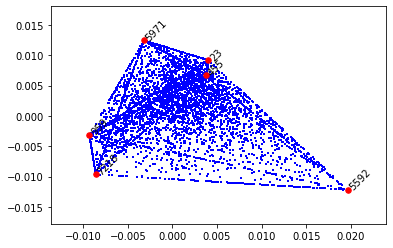

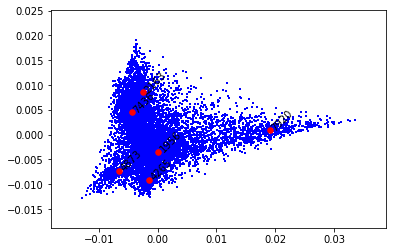

In [4]:
Cbar_m = X_magic / X_magic.sum(axis = 1)[:, None]
Cbar_m = Cbar_m.T @ Cbar_m / n
Cbar_m = Cbar_m / Cbar_m.sum(axis = 1)[:, None] 
S_m, _, _ = findS(Cbar_m, k)
Cbar_m = Cbar_proj(Cbar_m)

print(S_m)
print(X.toarray().sum(axis = 0)[S_m])
print(X.toarray().sum(axis = 0)[S0])

which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_m, S0, which_dim = which_dim, annotate=True,fontsize=10)


### Comment

Algo still picks rare words, but they are closer to true anchor words (except for one)... as MAGIC makes even the rare words contain enough information

## MAGIC  on $X^T$

In [5]:
Y_normalized = scprep.normalize.library_size_normalize(X.T) ## normalizing each gene; could amplify noise
Y_normalized = scprep.transform.sqrt(Y_normalized)
magic_op = magic.MAGIC()
magic_op.set_params(random_state = 12)
magic_op.fit(Y_normalized)

Running MAGIC on 8766 cells and 3207 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 0.68 seconds.
  Calculating KNN search...
  Calculated KNN search in 10.09 seconds.
  Calculating affinities...
  Calculated affinities in 9.84 seconds.
Calculated graph and diffusion operator in 20.62 seconds.


MAGIC(decay=1, knn=5, knn_dist='euclidean', knn_max=15, n_jobs=1, n_pca=100,
      random_state=12, solver='exact', t=3, verbose=1)

Calculating imputation...


/home/zihao/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 2.04 seconds.
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.3101 seconds

[8694 7914 4892 3416 7976 7780]
[ 253. 2723.  224.  378.  247.  148.]
[ 215. 1671.  421.  461.  520. 1023.]
recoverS with Cbar1


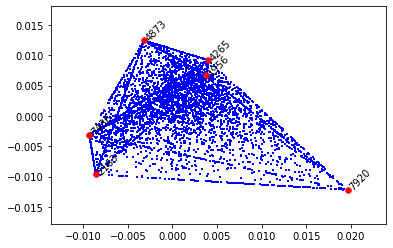

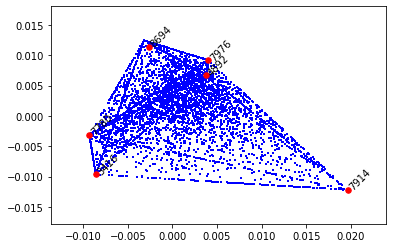

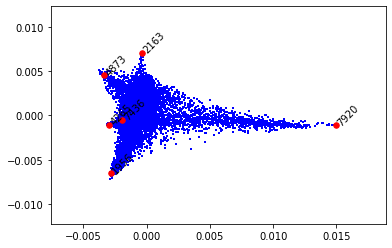

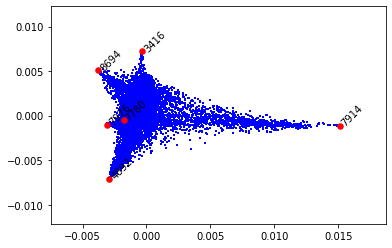

In [6]:
magic_op.set_params(t = 3)

Y_magic = magic_op.transform(X.T)
Cbar_m = Y_magic.T / Y_magic.T.sum(axis = 1)[:, None]
Cbar_m = Cbar_m.T @ Cbar_m / n
Cbar_m = Cbar_m / Cbar_m.sum(axis = 1)[:, None] 
S_m, _, _ = findS(Cbar_m, k)
Cbar_m = Cbar_proj(Cbar_m)


print(S_m)
print(X.toarray().sum(axis = 0)[S_m])
print(X.toarray().sum(axis = 0)[S0])


which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S0, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_m, S0, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_m, S_m, which_dim = which_dim, annotate=True,fontsize=10)

### Comment:

* We find great anchor words!
* The shrinkage reveals the anchor words very well. Not sure if it's too aggressive
* There are tuning parameters we can play with (likle $t$)

### Try different $t$

* Use small $t$: less shrinkage/average across genes, compared to large $t$


Calculating imputation...


/home/zihao/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 6.86 seconds.
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.3141 seconds

[8694 7914 7976 4892 3416 7780]
[ 253. 2723.  247.  224.  378.  148.]
[ 215. 1671.  421.  461.  520. 1023.]
recoverS with Cbar1


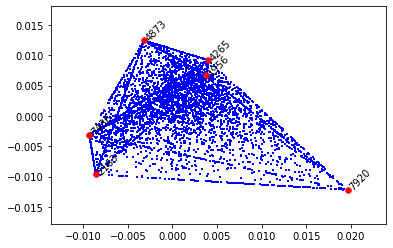

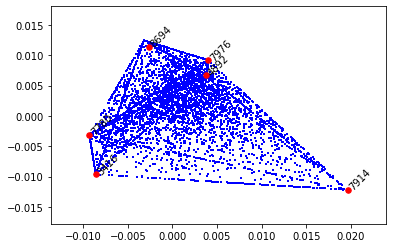

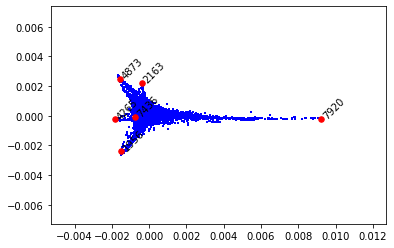

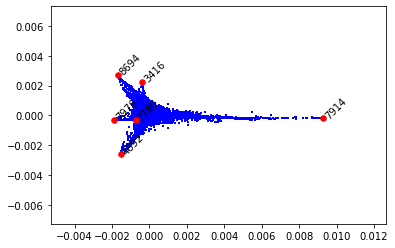

In [7]:
magic_op.set_params(t = 10)

Y_magic = magic_op.transform(X.T)
Cbar_m = Y_magic.T / Y_magic.T.sum(axis = 1)[:, None]
Cbar_m = Cbar_m.T @ Cbar_m / n
Cbar_m = Cbar_m / Cbar_m.sum(axis = 1)[:, None] 
S_m, _, _ = findS(Cbar_m, k)
Cbar_m = Cbar_proj(Cbar_m)


print(S_m)
print(X.toarray().sum(axis = 0)[S_m])
print(X.toarray().sum(axis = 0)[S0])


which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S0, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_m, S0, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_m, S_m, which_dim = which_dim, annotate=True,fontsize=10)


Calculating imputation...


/home/zihao/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 0.64 seconds.
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.3076 seconds

[3180 1449 6444 5720 1914  525]
[ 27.  13.   5.   6.   4. 156.]
[ 215. 1671.  421.  461.  520. 1023.]
recoverS with Cbar1


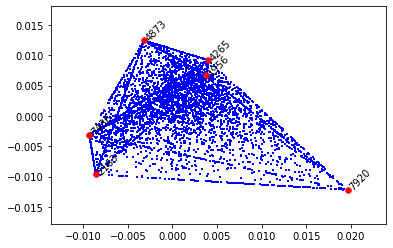

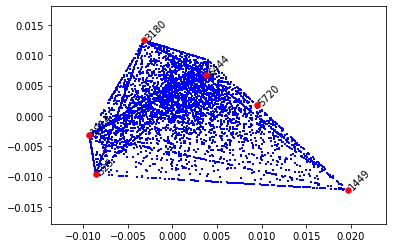

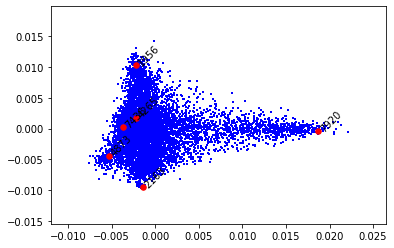

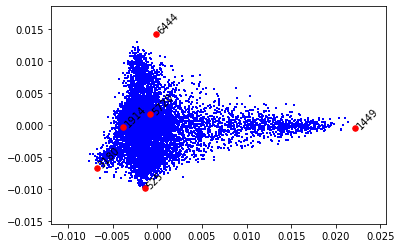

In [8]:
magic_op.set_params(t = 1)

Y_magic = magic_op.transform(X.T)
Cbar_m = Y_magic.T / Y_magic.T.sum(axis = 1)[:, None]
Cbar_m = Cbar_m.T @ Cbar_m / n
Cbar_m = Cbar_m / Cbar_m.sum(axis = 1)[:, None] 
S_m, _, _ = findS(Cbar_m, k)
Cbar_m = Cbar_proj(Cbar_m)


print(S_m)
print(X.toarray().sum(axis = 0)[S_m])
print(X.toarray().sum(axis = 0)[S0])


which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S0, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_m, S0, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_m, S_m, which_dim = which_dim, annotate=True,fontsize=10)


### Check diffusion matrix

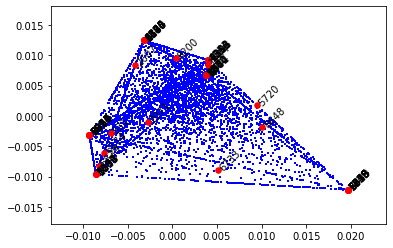

[ 18.  11.  16.   6.  24.  10.  40.  17.  20.  27.  11.   8.  10.  19.
  21.   8.   3.   7.   4.  13.   4.   6.   6.   3.   4.   7.   8.   1.
   4.   5.   4.  10.  17.  10.   6.  10.   5.   6.  12.   6.   5.   7.
   5.   3.   8.   4.   6.   2.  23.   4.  84. 403. 359. 437.  97. 428.
 159. 161. 130. 156.]
set()


In [9]:
weights = magic_op.diff_op[S_m,:].toarray()
nbh = []
for i in range(len(S_m)):
    nbh += np.argsort(weights[i,:])[-10:].tolist()
    
vis_extremal_pca(Cbar0_pj, nbh, which_dim = which_dim, annotate=True,fontsize=10)
print(X.toarray().sum(axis = 0)[nbh])
print(set(S0).intersection(set(nbh)))

### Try using diffusion matrix to find anchor words

Something wrong with SPA?

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.2456 seconds

[6039 5756 4106 6226 8074 6820]
[ 4. 10.  4.  3.  6.  6.]
[ 215. 1671.  421.  461.  520. 1023.]
recoverS with Cbar1


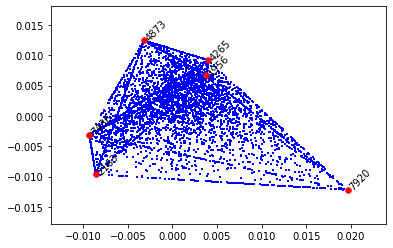

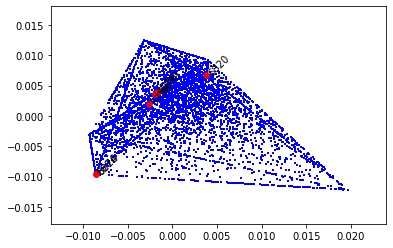

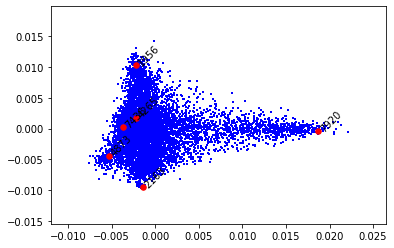

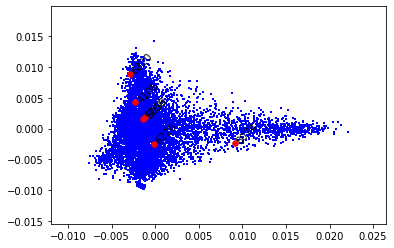

In [10]:
S_m, _, _ = findS(magic_op.diff_op.toarray(), k)


print(S_m)
print(X.toarray().sum(axis = 0)[S_m])
print(X.toarray().sum(axis = 0)[S0])


which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S0, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_m, S0, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_m, S_m, which_dim = which_dim, annotate=True,fontsize=10)


### No scaling of $X^T$ before computing distance

Previous experiment we scaled each gene to have the same total expression, take sqrt, then PCA to compute distance

In [11]:
Y_normalized = scprep.transform.sqrt(X.T)
magic_op = magic.MAGIC()
magic_op.set_params(random_state = 12)
magic_op.fit(Y_normalized)

Running MAGIC on 8766 cells and 3207 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 0.77 seconds.
  Calculating KNN search...
  Calculated KNN search in 8.92 seconds.
  Calculating affinities...
  Calculated affinities in 8.78 seconds.
Calculated graph and diffusion operator in 18.48 seconds.


MAGIC(decay=1, knn=5, knn_dist='euclidean', knn_max=15, n_jobs=1, n_pca=100,
      random_state=12, solver='exact', t=3, verbose=1)

Calculating imputation...


/home/zihao/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 2.08 seconds.
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.3129 seconds

[4086 7914 1843 5802  659   26]
[  59. 2723.   34.   16.   29.   19.]
[ 215. 1671.  421.  461.  520. 1023.]
recoverS with Cbar1


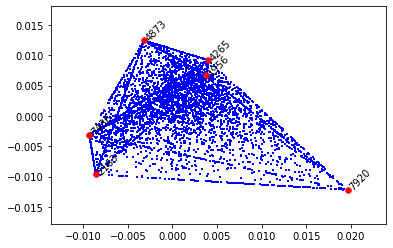

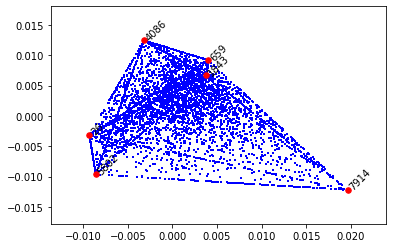

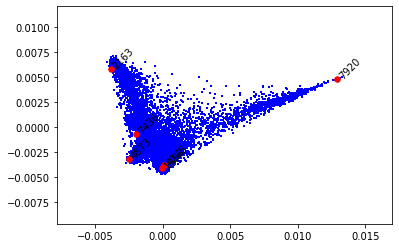

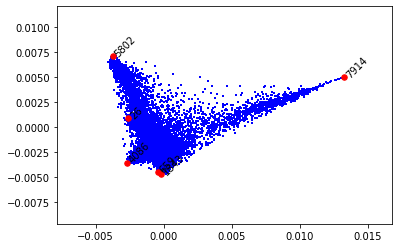

In [12]:
magic_op.set_params(t = 3)

Y_magic = magic_op.transform(X.T)
Cbar_m = Y_magic.T / Y_magic.T.sum(axis = 1)[:, None]
Cbar_m = Cbar_m.T @ Cbar_m / n
Cbar_m = Cbar_m / Cbar_m.sum(axis = 1)[:, None] 
S_m, _, _ = findS(Cbar_m, k)
Cbar_m = Cbar_proj(Cbar_m)


print(S_m)
print(X.toarray().sum(axis = 0)[S_m])
print(X.toarray().sum(axis = 0)[S0])


which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S0, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_m, S0, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_m, S_m, which_dim = which_dim, annotate=True,fontsize=10)


## Directly smoothing $\bar{C}$ matrix

Motivation: gene information is better captured by row of $C$ than a column of $X$?

Steps: use $C$ to get a good diffusion map; then smooth $\bar{C}$ using that diffusion map; finally scale $\bar{C}$ to make sure it sums to 1

In [13]:
Pi = X.toarray() / X.toarray().sum(axis = 1)[:, None]
C = Pi.T @ Pi / n
Cbar = C / C.sum(axis = 1)[:, None]

In [14]:
magic_op = magic.MAGIC()
magic_op.set_params(random_state = 12)
magic_op.fit(np.sqrt(C)) ## seem to get better anchor words

Running MAGIC on 8766 cells and 8766 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 4.51 seconds.
  Calculating KNN search...
  Calculated KNN search in 4.33 seconds.
  Calculating affinities...
  Calculated affinities in 4.16 seconds.
Calculated graph and diffusion operator in 13.01 seconds.


MAGIC(decay=1, knn=5, knn_dist='euclidean', knn_max=15, n_jobs=1, n_pca=100,
      random_state=12, solver='exact', t=3, verbose=1)

Running MAGIC with `solver='exact'` on 8766-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
Calculating imputation...


/home/zihao/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 7.54 seconds.
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.2649 seconds

[4093 8399 4393 4533 6244 1331]
[9. 7. 5. 5. 5. 4.]
[ 215. 1671.  421.  461.  520. 1023.]
recoverS with Cbar1


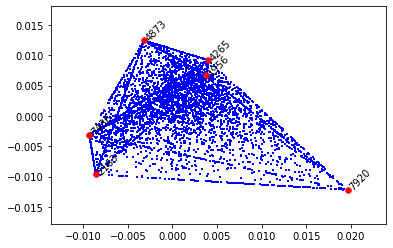

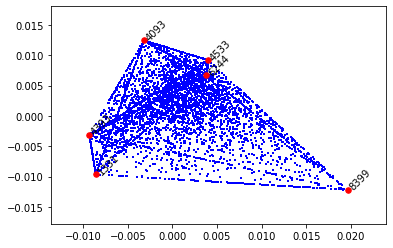

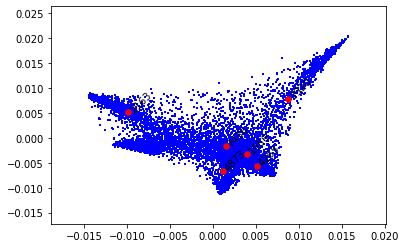

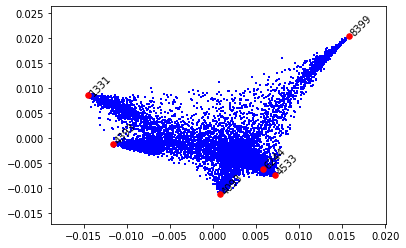

In [15]:
magic_op.set_params(t = 5)
C_magic = magic_op.transform(Cbar)
# C_magic = 0.5 * (C_magic + C_magic.T)

Cbar_m = C_magic / C_magic.sum(axis = 1)[:, None]
S_m, _, _ = findS(Cbar_m, k)
Cbar_m = Cbar_proj(Cbar_m)

print(S_m)
print(X.toarray().sum(axis = 0)[S_m])
print(X.toarray().sum(axis = 0)[S0])


which_dim = [0, 1]
print("recoverS with Cbar1")
vis_extremal_pca(Cbar0_pj, S0, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar0_pj, S_m, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_m, S0, which_dim = which_dim, annotate=True,fontsize=10)
vis_extremal_pca(Cbar_m, S_m, which_dim = which_dim, annotate=True,fontsize=10)